In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


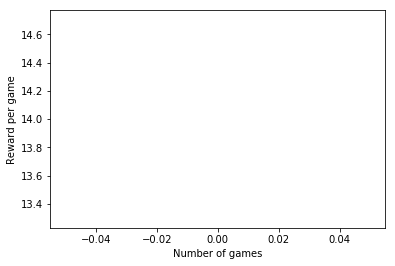

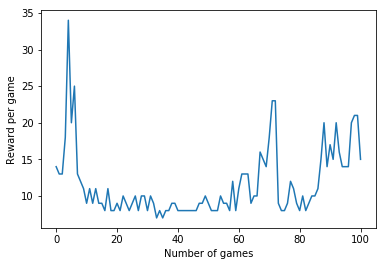

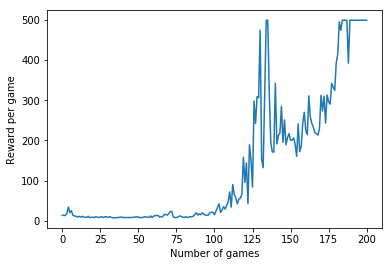

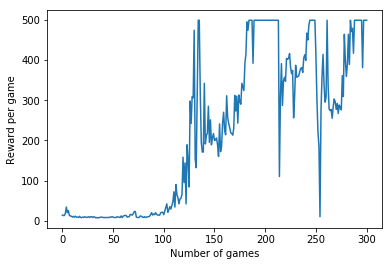

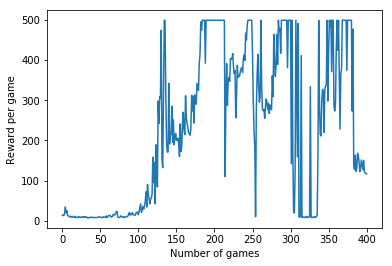

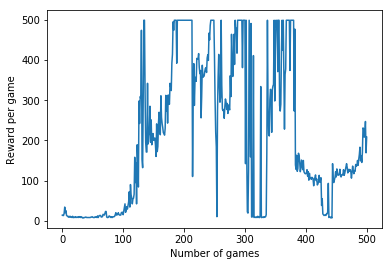

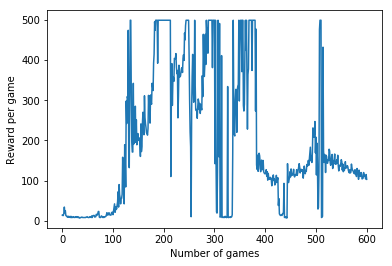

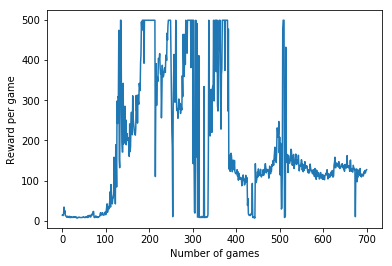

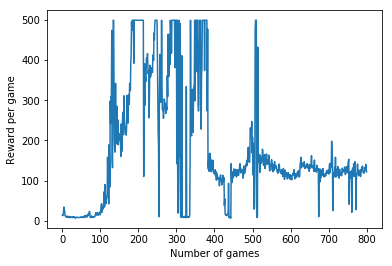

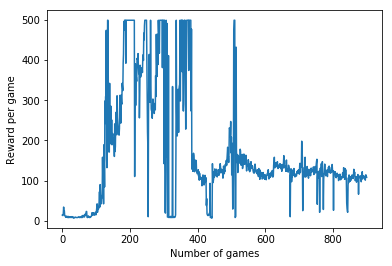

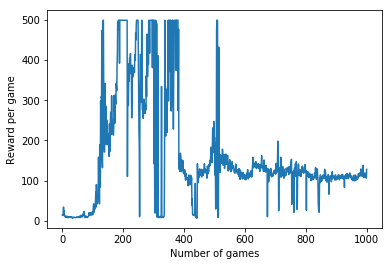

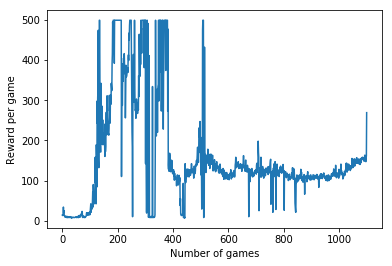

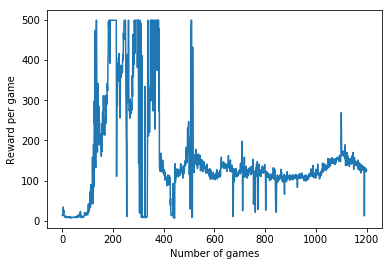

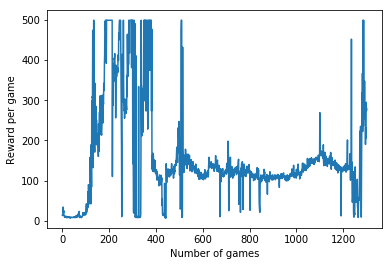

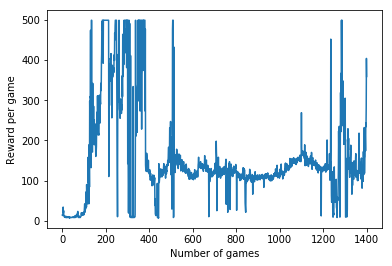

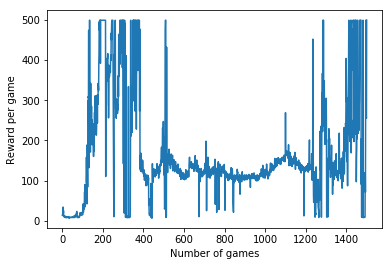

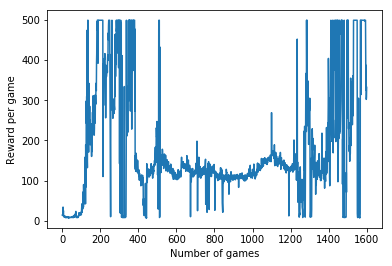

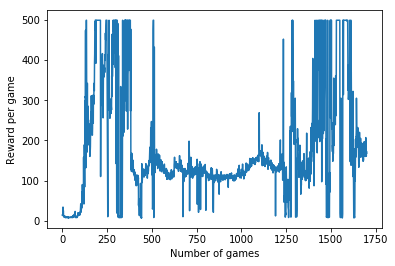

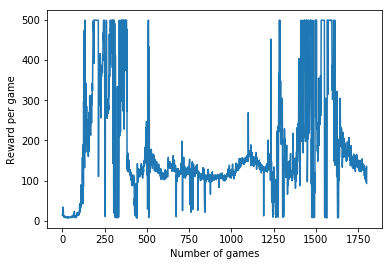

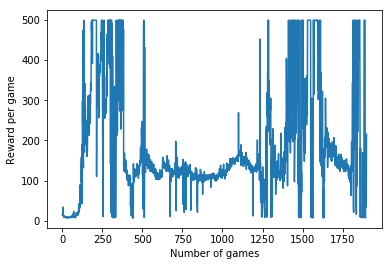

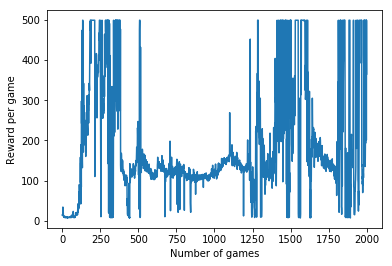

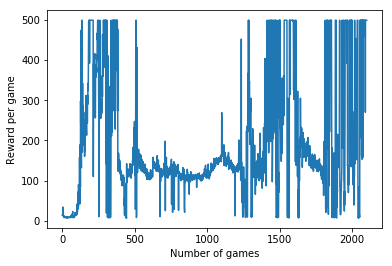

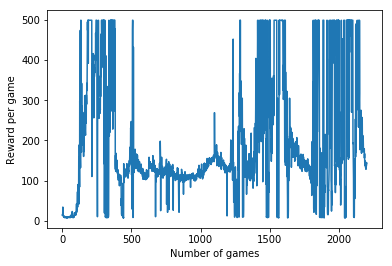

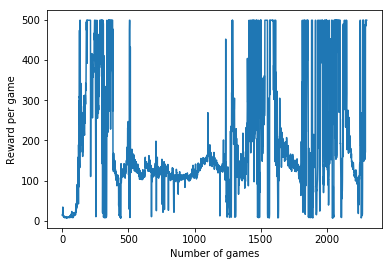

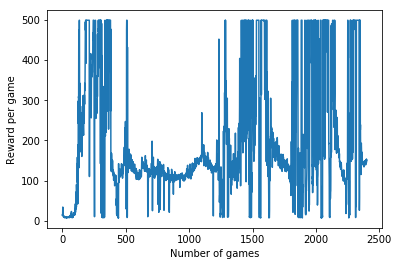

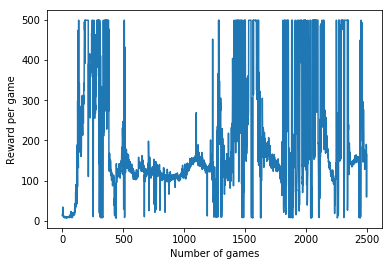

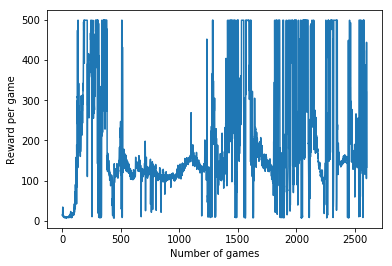

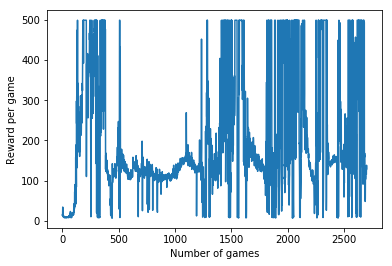

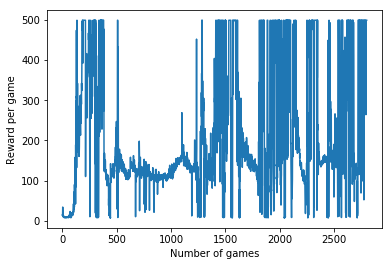

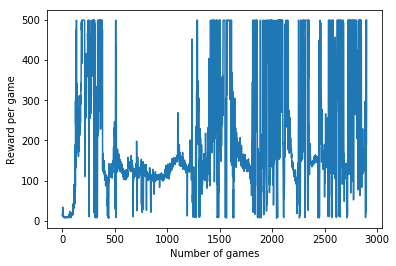

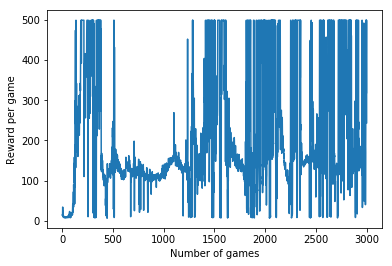

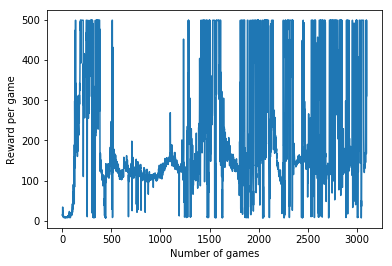

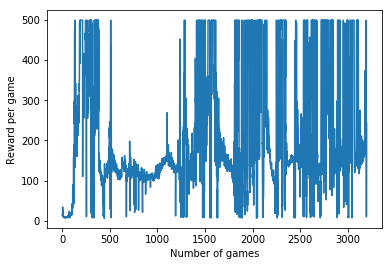

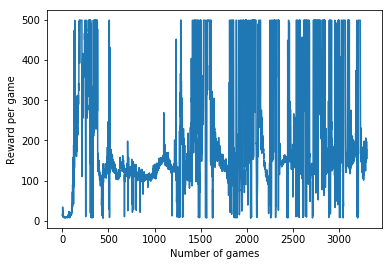

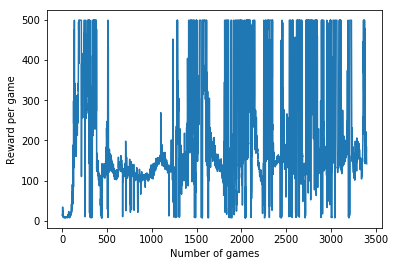

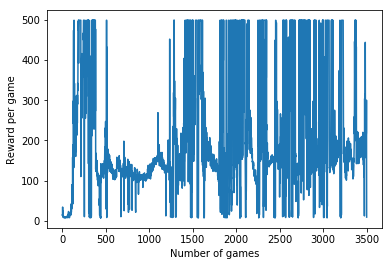

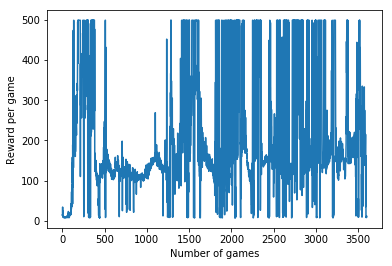

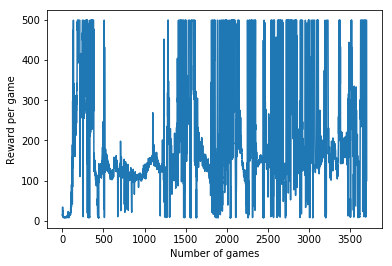

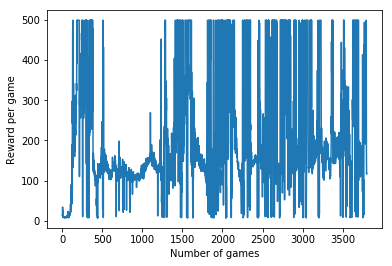

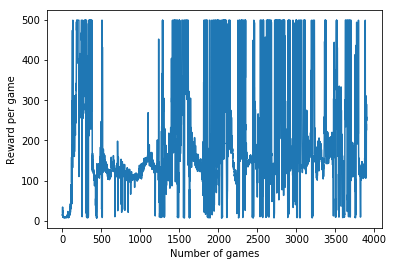

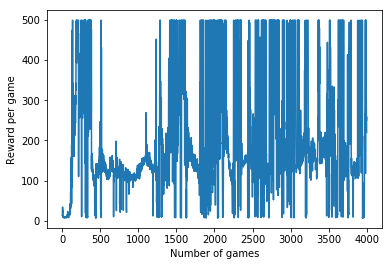

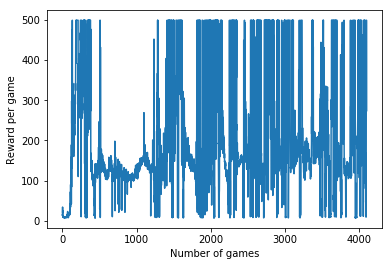

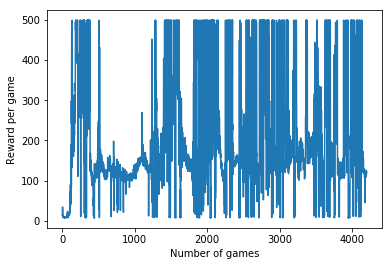

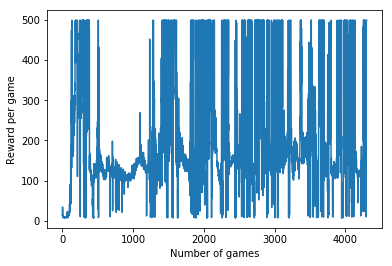

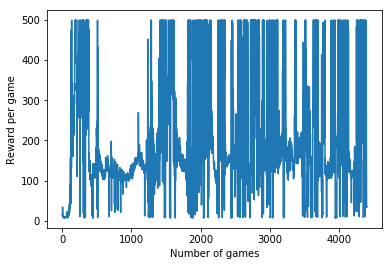

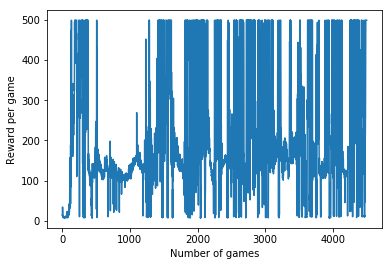

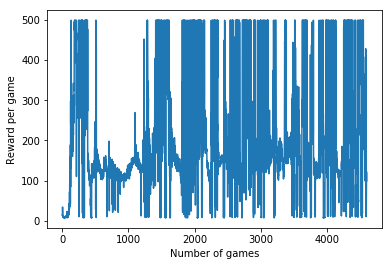

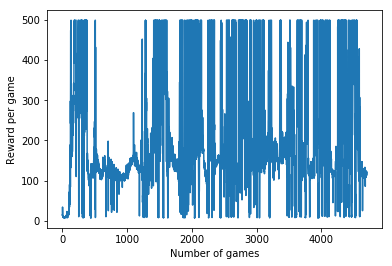

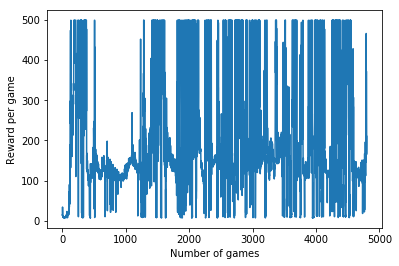

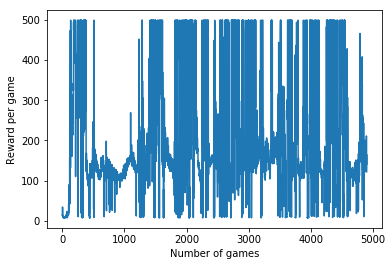

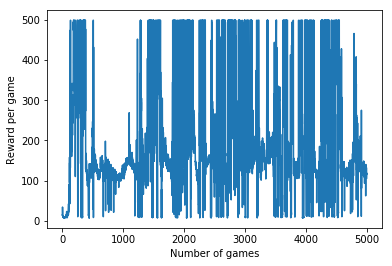

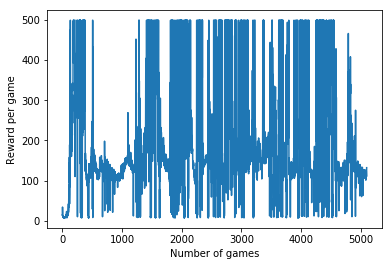

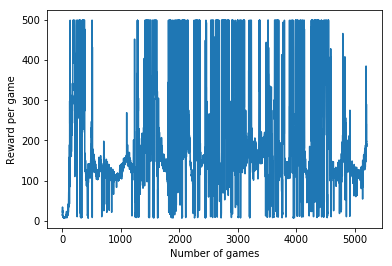

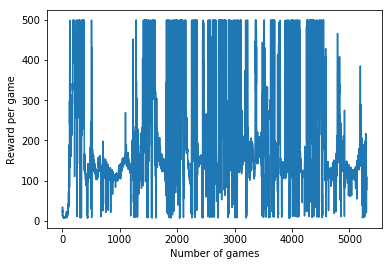

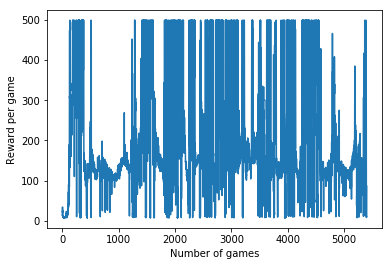

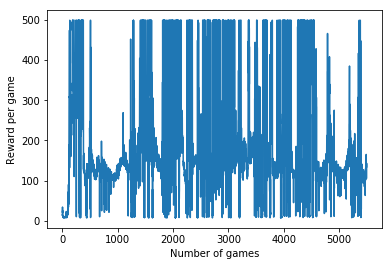

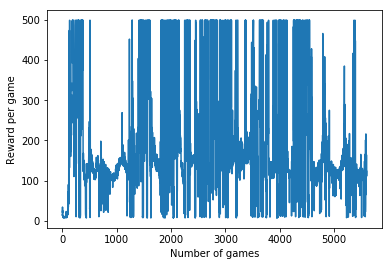

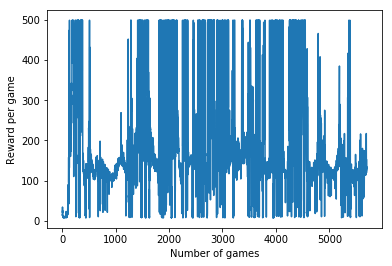

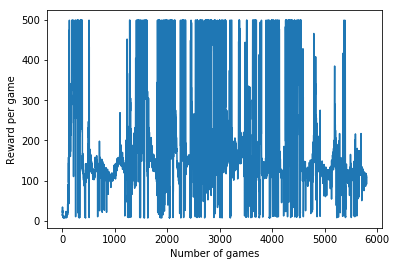

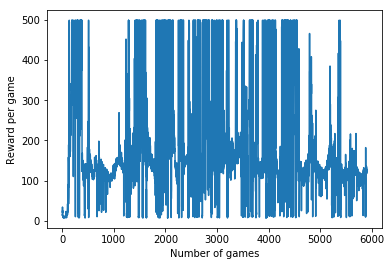

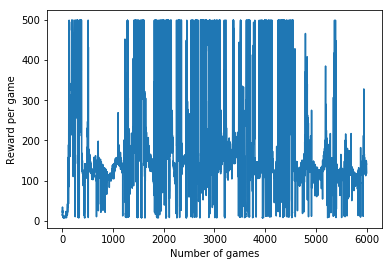

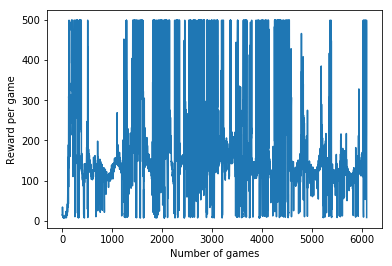

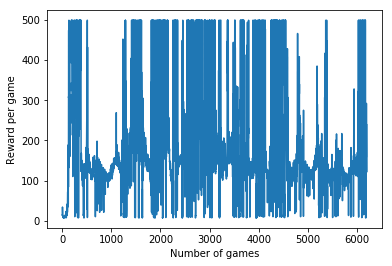

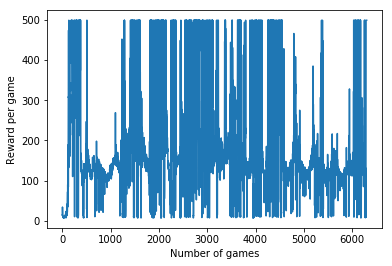

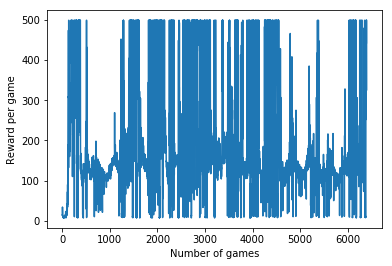

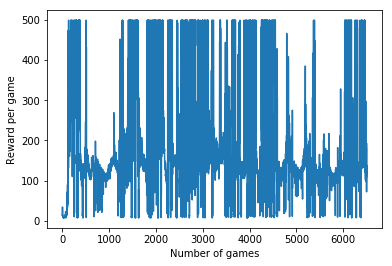

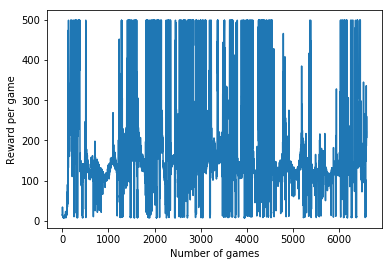

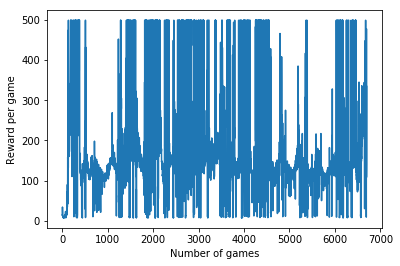

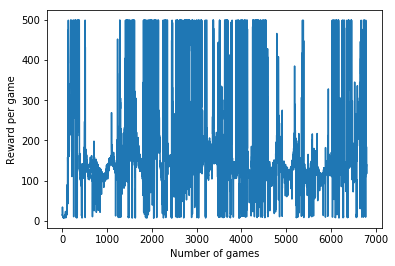

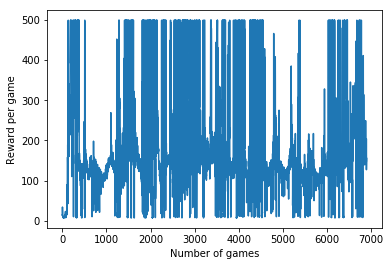

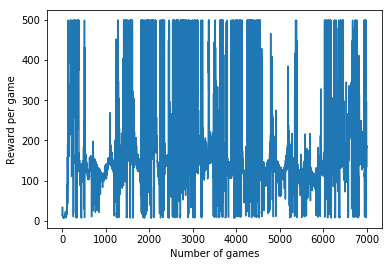

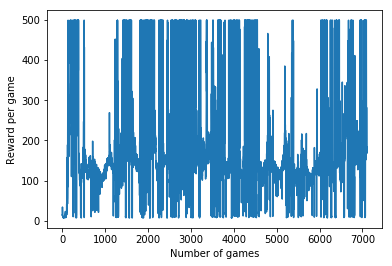

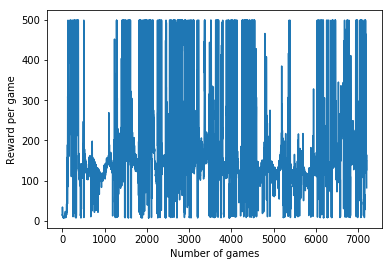

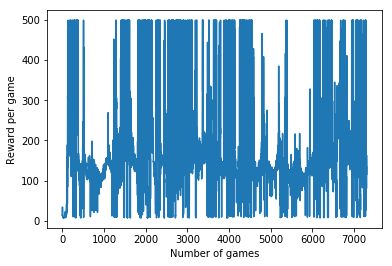

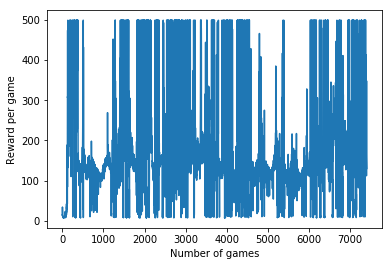

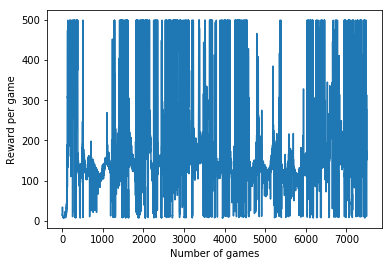

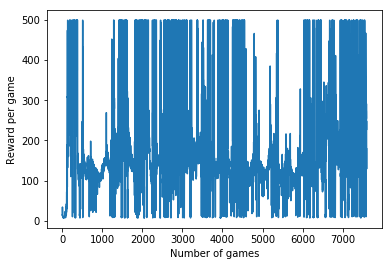

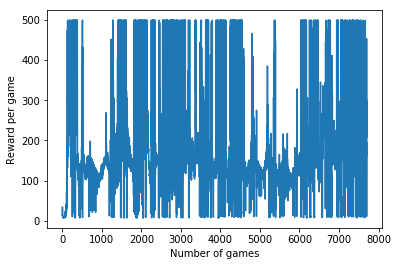

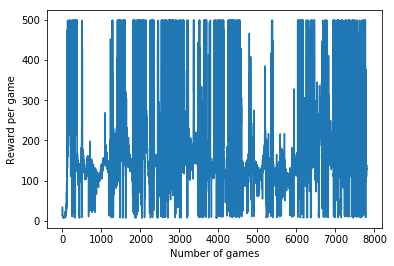

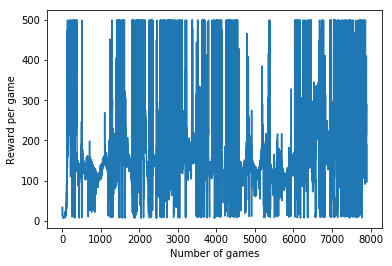

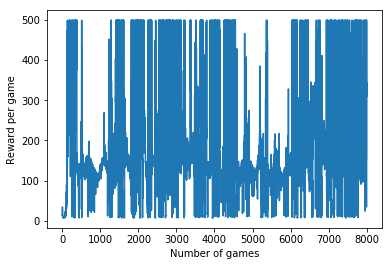

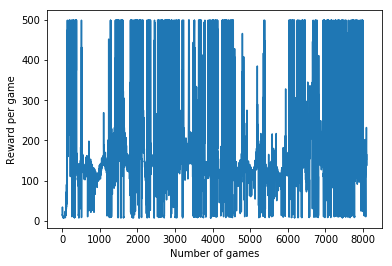

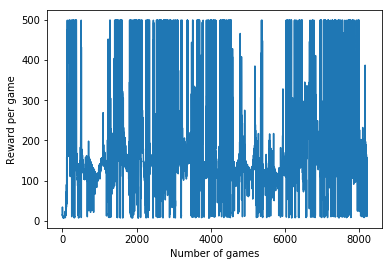

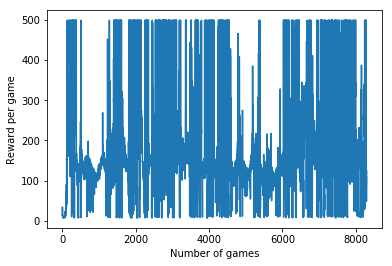

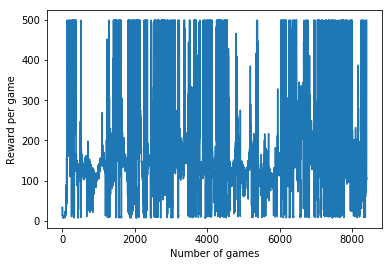

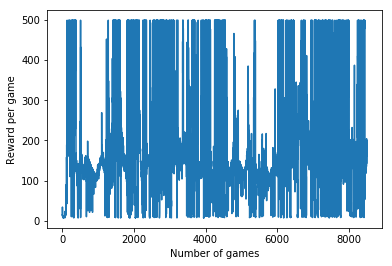

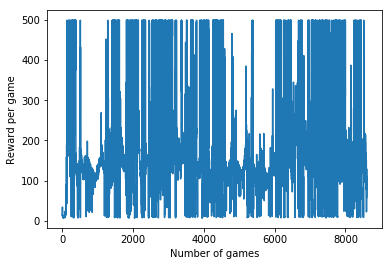

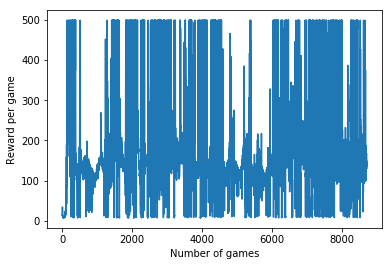

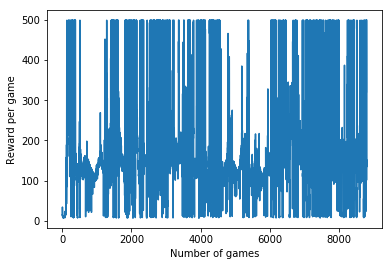

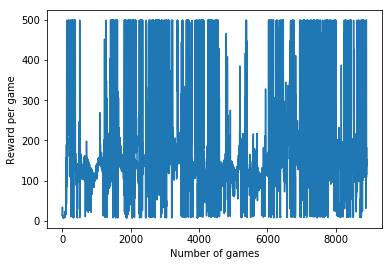

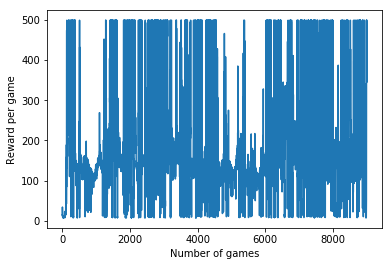

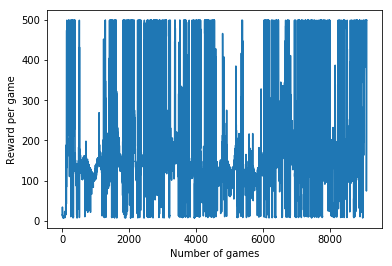

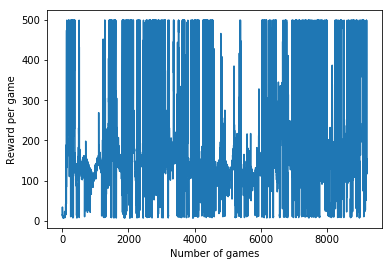

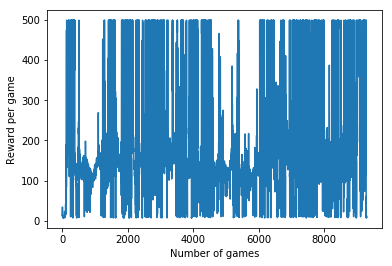

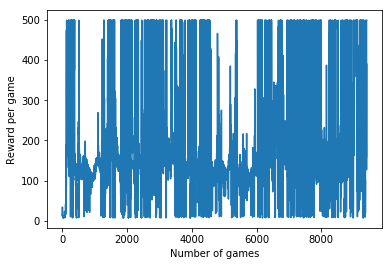

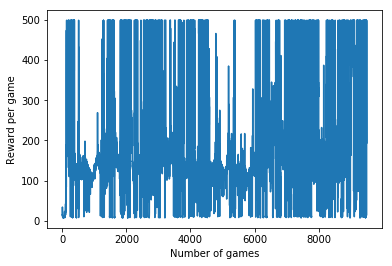

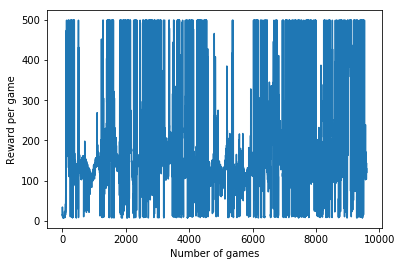

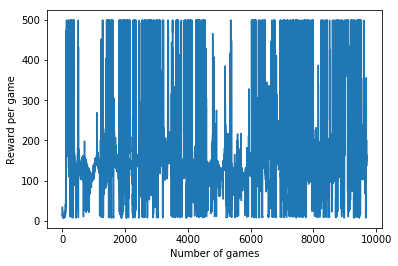

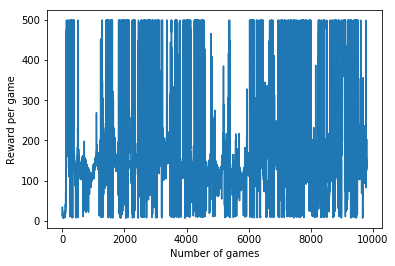

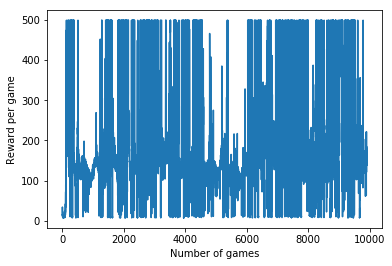

In [23]:
EPISODES = 10000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.94    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.008
        self.epsilon_decay = 0.990
        self.learning_rate = 0.00008
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


if __name__ == "__main__":
    r_list = []
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            # env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                #print("episode: {}/{}, score: {}, e: {:.2}"
                      #.format(e, EPISODES, time, agent.epsilon))
                r_list.append(time)
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        if e % 100 == 0:
            plt.plot(r_list)
            plt.ylabel('Reward per game')
            plt.xlabel('Number of games')
            plt.show()
        # if e % 10 == 0:
#     agent.save("./save/cartpole-dqn.h5")